Небольшой проект, где я с помощью Pandas проанализировала Яндекс-запросы за несколько недель, загрузив их из json-файла. Попробовала найти закономерности и отличия использования сервиса на мобильных платформах и компьютерах.

Загружаем и распаковываем архив с данными из открытого репозитория. Исходный архив содержит JSON-файл с информацией о поисковых запросах пользователей Яндекс.Картинок.

In [157]:
!git clone https://github.com/andron23/yandex-data.git

from zipfile import ZipFile
with ZipFile('yandex-data/data.zip', "r") as zip:
    zip.extractall(path='uncompressed')

fatal: destination path 'yandex-data' already exists and is not an empty directory.


Загружаем данные в pandas.DataFrame для дальнейшего анализа. На этом этапе видно, что в таблице содержатся три колонки:

query — поисковый запрос,

ts — временная метка (timestamp),

platform — платформа пользователя (например, touch или desktop).

In [159]:
import pandas as pd
df = pd.read_json('uncompressed/data.json')
df.head()

,query,ts,platform
0,порно фото,1631786697,touch
1,малевич картины,1631806465,desktop
2,Секс,1631781583,touch
3,с днём рождения лена,1631771563,touch
4,зверополис порно,1631787599,touch


Все поисковые запросы привожу к нижнему регистру для унификации.

Преобразую временную метку в читаемый формат datetime. Прибавляю +3 часа для приведения к московскому времени (UTC+3).

Далее создала отдельную колонку ts2, содержащую только дату (без времени), чтобы агрегировать данные по дням.



Все это делаю, чтобы понять, как с течением времени меняется запрос яндекс картинок и с чем это связано

In [278]:
df['query'] = df['query'].str.lower() 
df['ts'] = pd.to_datetime(df['ts'], unit = 's') + pd.Timedelta(hours = 3) 
df['ts2'] = df['ts'].dt.strftime('%Y-%m-%d') 
df.head()

,query,ts,platform,ts2,hour
0,порно фото,2021-09-16 16:04:57,touch,2021-09-16,13
1,малевич картины,2021-09-16 21:34:25,desktop,2021-09-16,18
2,секс,2021-09-16 14:39:43,touch,2021-09-16,11
3,с днём рождения лена,2021-09-16 11:52:43,touch,2021-09-16,8
4,зверополис порно,2021-09-16 16:19:59,touch,2021-09-16,13


Построила линейный график, который отображает количество просмотров яндекс картинок по дням, чтобы отследить колебания пользовательской активности с течением времени.

           ts2  count
0   2021-09-01  65780
1   2021-09-02  52876
2   2021-09-03  53636
3   2021-09-04  47895
4   2021-09-05  53780
5   2021-09-06  56900
6   2021-09-07  57379
7   2021-09-08  61378
8   2021-09-09  59582
9   2021-09-10  53229
10  2021-09-11  49987
11  2021-09-12  56424
12  2021-09-13  60768
13  2021-09-14  60226
14  2021-09-15  59808
15  2021-09-16  58428
16  2021-09-17  56838
17  2021-09-18  51812
18  2021-09-19  57235
19  2021-09-20  63160
20  2021-09-21  66703


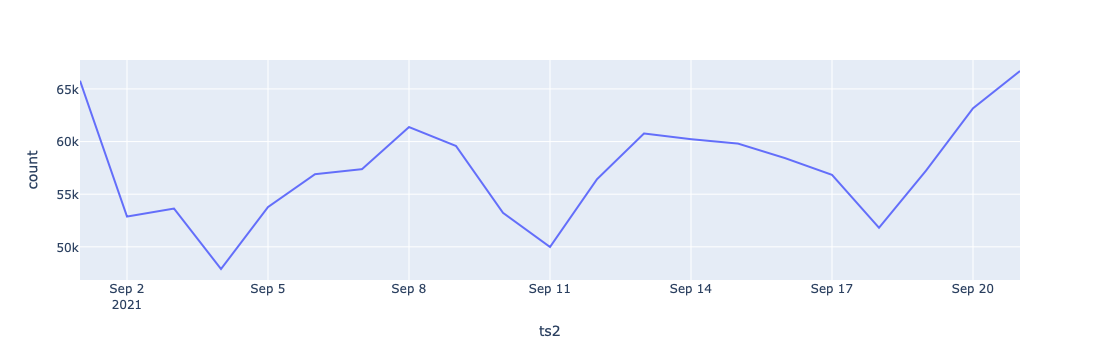

In [176]:
import plotly.express as px
df1 = (
    df
    .groupby(['ts2'])['query']
    .agg({'count'})
    .reset_index()
    )
print(df1)
px.line(df1, x = 'ts2', y = 'count')

Вывела информацию о 10 самых популярных запросов по каждой платформе.

In [195]:
top_queries = (
    df
    .groupby(['platform', 'query'])           
    .size()                                  
    .reset_index(name='count')               
    .sort_values(['platform', 'count'], ascending=[True, False])  
    .groupby('platform')                     
    .head(10)                               
    .reset_index(drop=True)                  
)

top_queries

,platform,query,count
0,desktop,календарь 2021,2810
1,desktop,таблица менделеева,2659
2,desktop,картинки,1720
3,desktop,порно,1408
4,desktop,английский алфавит,1352
5,desktop,обои на рабочий стол,1143
6,desktop,одноклассники (социальная сеть),1116
7,desktop,секс,947
8,desktop,алфавит,923
9,desktop,таблица квадратов,883


Добавила колонку wd для дня недели, чтобы построить барчарт распределения количества просмотров по дням недели.

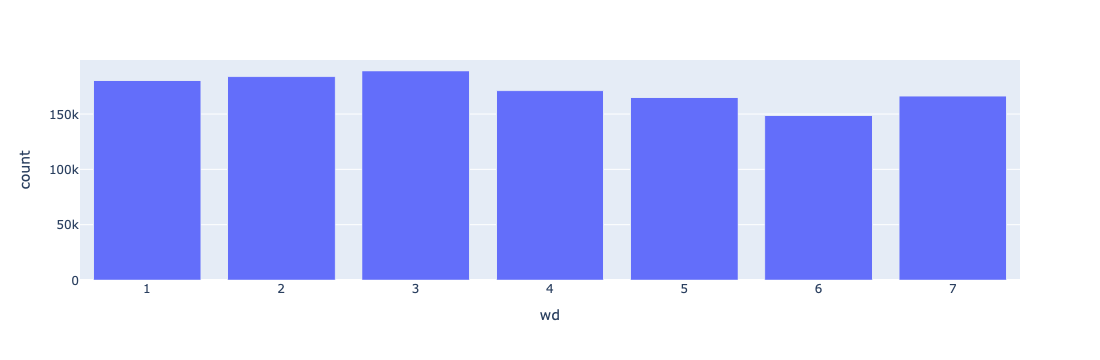

In [280]:
df['wd'] = df['ts'].dt.dayofweek + 1 

px.bar(
    (
        df
        .groupby(['wd'], as_index=False)
        ['ts']
        .agg({'count'})
    ),
    x = 'wd',
    y = 'count'
)

Нахожу уникальные фразы, которые хотя бы 1 раз входили в топ-3 по количеству запросов в каждый час суток

In [225]:
df['hour'] = df['ts'].dt.hour

most_popular_phrases = set()

for h in sorted(df['hour'].unique()):
    most_popular_phrases.update(
        df[df['hour'] == h]
        .groupby(['query'])['ts']
        .agg('count')
        .sort_values(ascending=False)
        .head(3)
        .index
        .tolist()
    )
most_popular_phrases

{'xxx',
 'доброе утро',
 'календарь 2021',
 'порно',
 'с днём рождения',
 'с днём рождения женщине',
 'секс',
 'таблица менделеева',
 'хентай'}

Создаю таблицу с количеством запросов по часу и платформе и строю график, где видно, как часто искали топ-фразы в разные часы в течение суток

In [220]:
top_df = (
    df
    [df['query'].isin(most_popular_phrases)]
    .groupby(['platform', 'query', 'hour'], as_index=False)
    .agg({'ts': 'count'})
    .rename(columns={'ts': 'count'})
)
top_df

,platform,query,hour,count
0,desktop,xxx,0,8
1,desktop,xxx,1,5
2,desktop,xxx,2,4
3,desktop,xxx,3,1
4,desktop,xxx,5,2
...,...,...,...,...
423,touch,хентай,19,214
424,touch,хентай,20,264
425,touch,хентай,21,228
426,touch,хентай,22,280


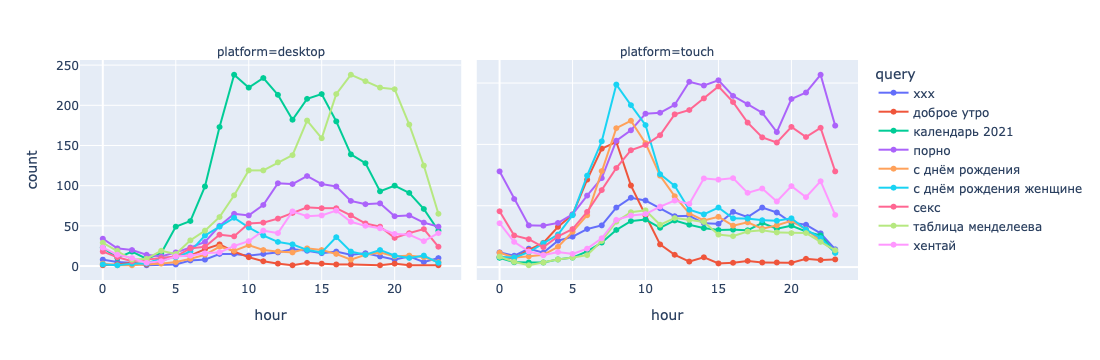

In [230]:
fig = px.line(
    top_df,
    x = 'hour',
    y = 'count',
    color = 'query',
    facet_col='platform',
    markers = True

)
fig.update_yaxes(matches = None)
fig.show()

Далее стоит задача найти запросы, которые часто гуглят на touch но редко на desktop и наоборот.

Для этого строю таблицу df3, которая показывает агрегированную статистику по популярности запросов в зависимости от платформы.
Для каждого уникального запроса подсчитано количество его появлений на каждой платформе (оставила только те запросы, количество появлений которых > 15), чтобы в дальнейшем при построении графиков убрать выбросы.
Добавила показатели desktop_rel и touch_rel, которые показываю популярность каждого запроса в сравнении с самым популярным на каждой из платформ.
Колонка diff показывает разницу между кол-вом запросов на desktop и touch, чтобы понять, какой запрос на какой платформе популярнее.

In [232]:
df3 = (
    df
    .groupby(['platform', 'query'], as_index = False)
    ['ts']
    .agg({'count'})
    .pivot_table(
        index = 'query',
        columns = 'platform',
        values = 'count',
        fill_value = 0
    )
    .sort_values('desktop', ascending = False)
)
df3['summa'] = df3['desktop'] + df3['touch']
df3 = df3[df3['summa']>15]
df3['desktop_rel'] = df3['desktop'] / max(df3['desktop'])
df3['touch_rel'] = df3['touch'] / max(df3['touch'])
df3['diff'] = df3['desktop'] - df3['touch']
df3

platform,desktop,touch,summa,desktop_rel,touch_rel,diff
query,,,,,,
календарь 2021,2810.0,2268.0,5078.0,1.000000,0.225089,542.0
таблица менделеева,2659.0,2278.0,4937.0,0.946263,0.226082,381.0
картинки,1720.0,1801.0,3521.0,0.612100,0.178742,-81.0
порно,1408.0,10076.0,11484.0,0.501068,1.000000,-8668.0
английский алфавит,1352.0,1749.0,3101.0,0.481139,0.173581,-397.0
...,...,...,...,...,...,...
опята ложные как отличить,0.0,24.0,24.0,0.000000,0.002382,-24.0
смешные картинки хорошего дня,0.0,37.0,37.0,0.000000,0.003672,-37.0
смешные картинки с добрым утром,0.0,21.0,21.0,0.000000,0.002084,-21.0


Построила box plot, который отражает сумму каждого из запросов (которые встречались > 15 раз) по обеим платформам.

Он показал:

общее число уникальных запросов - 20 378

среднее кол-во запросов на одну фразу около 57

медиана = 30, половина запросов встречается не более 30 раз

нижний квартиль = 22, верхний = 49, большинство популярных запросов находится в диапозоне от 22 до 49

максимальное значение 11 484, говорят о наличии очень популярных запросов, которые выбиваются от количества запросов большинства фраз

среднеквадратическое отклонение = 174, что говорит о сильном разбросе данных

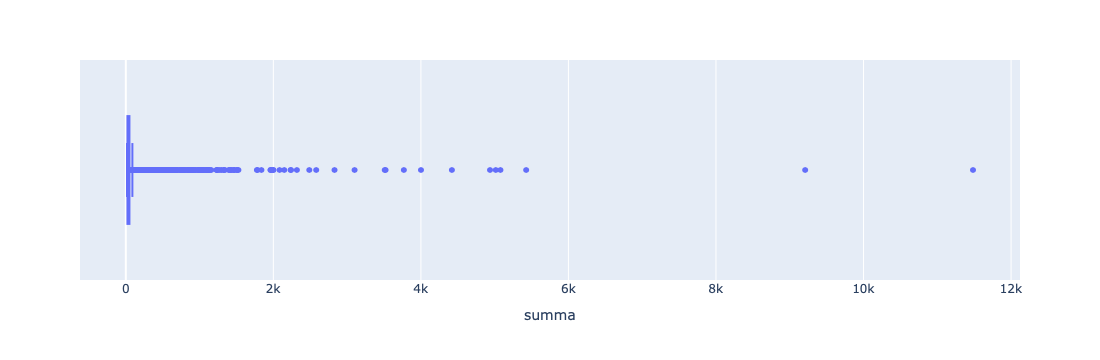

In [245]:
px.box(df3, x = 'summa')

In [247]:
summary = df3['summa'].describe(percentiles=[0.25, 0.5, 0.75])
print(summary)

count    20378.000000
mean        57.061046
std        174.367463
min         16.000000
25%         22.000000
50%         30.000000
75%         49.000000
max      11484.000000
Name: summa, dtype: float64


Тут вычисляю два квантиля для столбца diff, который показывает разницу в количестве запросов между платформами desktop и touch. Первый квантиль (33%) помогает определить нижнюю границу, ниже которой находятся примерно треть значений diff. Второй квантиль (99%) показывает верхнюю границу, выше которой находятся самые экстремальные значения.

Затем фильтрую данные, чтобы получить запросы, у которых разница в популярности между платформами значительно выделяется: либо больше 35 в пользу desktop, либо меньше -51 в пользу touch.

In [250]:
import numpy as np
np.quantile(df3['diff'], 0.33), np.quantile(df3['diff'], 0.99)

(-16.0, 62.0)

In [252]:
df3[(df3['diff'] > 35) | (df3['diff'] < -51)]

platform,desktop,touch,summa,desktop_rel,touch_rel,diff
query,,,,,,
календарь 2021,2810.0,2268.0,5078.0,1.000000,0.225089,542.0
таблица менделеева,2659.0,2278.0,4937.0,0.946263,0.226082,381.0
картинки,1720.0,1801.0,3521.0,0.612100,0.178742,-81.0
порно,1408.0,10076.0,11484.0,0.501068,1.000000,-8668.0
английский алфавит,1352.0,1749.0,3101.0,0.481139,0.173581,-397.0
...,...,...,...,...,...,...
открытки с днём знаний,0.0,57.0,57.0,0.000000,0.005657,-57.0
обои на телефон красивые,0.0,71.0,71.0,0.000000,0.007046,-71.0
онлайн казино,0.0,55.0,55.0,0.000000,0.005459,-55.0


Стобы оценить схожесть популярности запросов между двумя платформами, построила scatter plot, где по оси X отложено количество запросов на desktop, а по оси Y — количество запросов на touch.

Результат представляет собой практически идеальную прямую, что показывает высокую корреляцию и пропорциональность популярности запросов на обеих платформах. Это означает, что запросы, которые часто ищут на desktop, с такой же частотой ищут на touch, и наоборот.

Можно сделать вывод, что для большинства популярных запросов наблюдается сбалансированный интерес пользователей на разных устройствах)

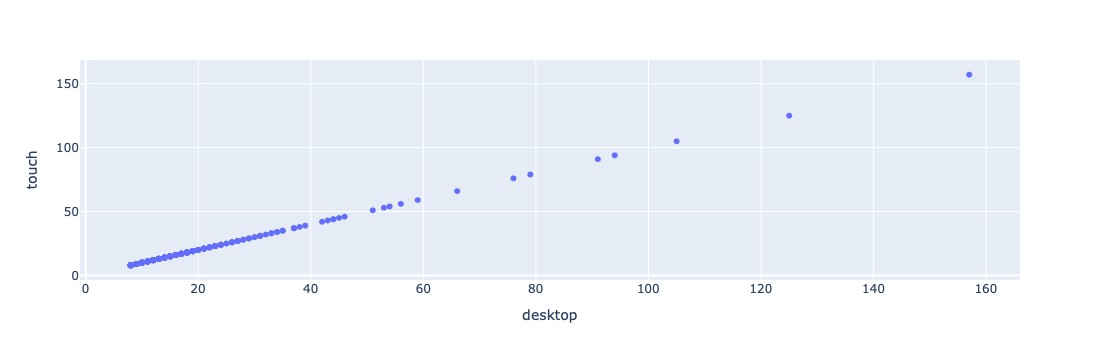

In [269]:

df4 = df3[(df3['diff'] > -1) & (df3['diff'] < 1)]
px.scatter(
    df4,
    x = 'desktop',
    y = 'touch'
)